# Prototype of a recommender

### Resources used


# Import packages

In [211]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Packages required for Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
from keras.layers import Concatenate, Dense, Dropout

# Load data
For this prototype I use the [Amazon Product Reviews](https://www.kaggle.com/saurav9786/amazon-product-reviews) dataset from [Kaggle](www.kaggle.com). 

The dataset includes data on electronic products from Amazon. I added the column names in the dataset manually as they were not maintained before.

In [212]:
electronics_ratings = pd.read_csv("ratings_electronics.csv")

electronics_ratings.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


# Data Analysis

## Results of data analysis
#### General information
- Dataset has 7,824,482 rows and 4 columns:
    - **userId (object):** Every user identified with a unique id (First Column)
    - **productId (object):** Every product identified with a unique id(Second Column)
    - **rating (float64):** Rating of the corresponding product by the corresponding user(Third Column)
    - **timestamp (int64):** Time of the rating ( Fourth Column)
 
- **No values are missing** in neither of the columns

#### Information on ratings
- There are 7,824,482 ratings in the dataset.
- Ratings range from 1.0 to 5.0
- The ratings are heavily skwed with more than half of the ratings being rated with 5.0. This is also shown in the mean which is 4.01.

#### Information on releation between ratings and users
- There are 4,201,696 unique users in the dataset.
- On average each user rates 1.86 products.
- The plot "Number of ratings per user" also visualizes that most of the user make on average 1.86 ratings. However, there are also some clear outliers. Fousing at the top 4.25 % of the users, each of them makes more than 5 ratings. The user with the most ratings made 520 ratings.

#### Information on releation between ratings and products
- There are 476,002 unique products in the dataset.
- On average each product is rated by 16.44 users.
- The plot "Number of ratings per product" also visualizes that most of the products receive on average 16.44 ratings. However, there are also some clear outliers. Fousing at the top 6.74 % of the users, each of them receives more than 20 ratings. The product with the most ratings received 18,244 ratings.

## General information

In [4]:
# Check the shape of dataset
electronics_ratings.shape

(7824482, 4)

In [5]:
# Check the datatypes of each column
electronics_ratings.dtypes

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

In [6]:
# Check for missing values
print('Number of missing values across columns:\n{}'.format(electronics_ratings.isnull().sum()))

Number of missing values across columns:
userId       0
productId    0
rating       0
timestamp    0
dtype: int64


In [43]:
# Drop timestamp column as it is not required
electronics_ratings.drop(['timestamp'], axis=1,inplace=True)

## Information on ratings

In [8]:
# Five point summary of rating column
electronics_ratings.describe()['rating']

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Text(0.5, 1.0, 'Distribution of product ratings')

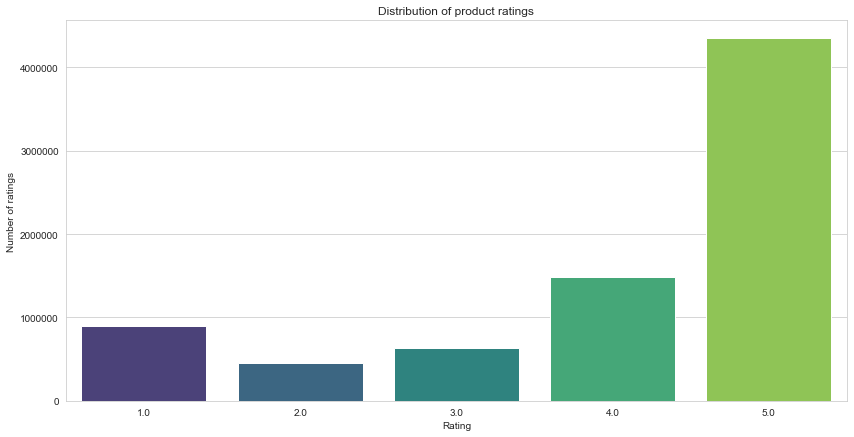

In [9]:
# Shows the distribution of product ratings
sns.set_style("whitegrid")
plt.figure(figsize=(14,7))
plt.subplot()
ax = sns.countplot(x="rating", data=electronics_ratings, palette="viridis")
plt.xlabel("Rating")
plt.ylabel("Number of ratings")
plt.title("Distribution of product ratings")

## Information on releation between ratings and users

In [10]:
# Gets number of ratings per user
number_of_ratings_per_user = electronics_ratings[['userId', 'productId']].groupby('userId').count().reset_index().sort_values(by=["productId"], ascending=False)
number_of_ratings_per_user.columns = ['UserId', 'Number of Ratings']
number_of_ratings_per_user.head()

,UserId,Number of Ratings
3263531,A5JLAU2ARJ0BO,520
3512451,ADLVFFE4VBT8,501
2989526,A3OXHLG6DIBRW8,498
3291008,A6FIAB28IS79,431
3284634,A680RUE1FDO8B,406


In [11]:
# Get five point summary to get better understanding about distribution of the ratings per user
number_of_ratings_per_user.describe()

,Number of Ratings
count,4.201696e+06
mean,1.862220e+00
std,2.885110e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,5.200000e+02


Text(0.5, 0, 'Value at the quantile')

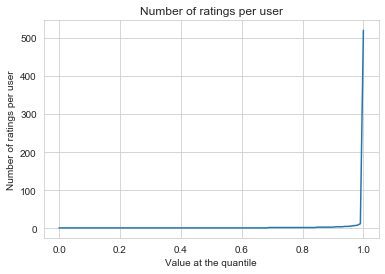

In [12]:
# Shows the number of ratings per user mapped to quantiles
quantiles = number_of_ratings_per_user.quantile(np.arange(0,1.01,0.01))
plt.plot(quantiles)
plt.title("Number of ratings per user")
plt.ylabel('Number of ratings per user')
plt.xlabel('Value at the quantile')

In [13]:
# Percentage of users that makes more than 5 ratings
total_users = sum(number_of_ratings_per_user.iloc[:,1] >= 0)
fraction_users = sum(number_of_ratings_per_user.iloc[:,1] > 5)
percentage = fraction_users/total_users*100

print('Total number of users: {}'.format(total_users))
print('Number of users making more than 5 ratings: {}'.format(fraction_users))
print('% of users making more than 5 rating: {:.2f} %'.format(percentage))

Total number of users: 4201696
Number of users making more than 5 ratings: 178669
% of users making more than 5 rating: 4.25 %


## Information on releation between ratings and products

In [14]:
# Gets number of ratings per product
number_of_ratings_per_product = electronics_ratings[['productId', 'userId']].groupby('productId').count().reset_index().sort_values(by=["userId"], ascending=False)
number_of_ratings_per_product.columns = ['ProductId', 'Number of Ratings']
number_of_ratings_per_product.head()

,ProductId,Number of Ratings
308398,B0074BW614,18244
429572,B00DR0PDNE,16454
327308,B007WTAJTO,14172
102804,B0019EHU8G,12285
296625,B006GWO5WK,12226


In [15]:
# Get five point summary to get better understanding about distribution of the ratings per user
number_of_ratings_per_product.describe()

,Number of Ratings
count,476002.000000
mean,16.437918
std,112.702633
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,18244.000000


Text(0.5, 0, 'Value at the quantile')

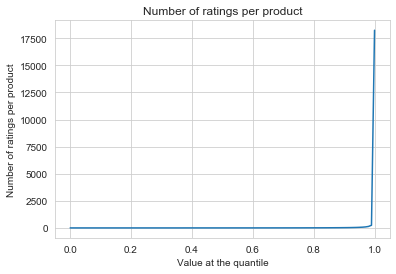

In [16]:
# Shows the number of ratings per product
quantiles = number_of_ratings_per_product.quantile(np.arange(0,1.01,0.01))
plt.plot(quantiles)
plt.title("Number of ratings per product")
plt.ylabel('Number of ratings per product')
plt.xlabel('Value at the quantile')

In [17]:
# Percentage of products that get more than 20 ratings

total_products = sum(number_of_ratings_per_product.iloc[:,1] >= 0)
fraction_products = sum(number_of_ratings_per_product.iloc[:,1] >= 20)
percentage = fraction_products/total_products*100

print('Total number of products: {}'.format(total_products))
print('Number of products getting more than 20 ratings: {}'.format(fraction_products))
print('% of products getting more than 20 ratings: {:.2f} %'.format(percentage))

Total number of products: 476002
Number of products getting more than 20 ratings: 57791
% of products getting more than 20 ratings: 12.14 %


# Neural Collaborativ Filtering

Used the following implementations as a basis for the prototype:
- https://keras.io/examples/structured_data/collaborative_filtering_movielens/
- https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929

In [213]:
electronics_ratings = pd.read_csv("ratings_electronics.csv")

electronics_ratings.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [214]:
# Reduce data set due to limited computational power of personal computer 
electronics_ratings = electronics_ratings.head(150000)

# Shuffle data to ensure that the model remains generalized and does not overfit as suggested here:
# https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks
electronics_ratings = electronics_ratings.sample(frac=1, random_state=42)

In [215]:
# Create a new user column with sequential integers using LabelEncoder
# This is required 
user_encoder = LabelEncoder()
electronics_ratings['user'] = user_encoder.fit_transform(electronics_ratings['userId'].values)

electronics_ratings.head()

,userId,productId,rating,timestamp,user
59770,A2CTXKY2EG7YBO,B00004WHFD,5.0,1022025600,47638
21362,A292403A8I1KUA,B00001P4XA,2.0,1247788800,43982
127324,AW11P3PUMIK0L,B00005UKBM,1.0,1007942400,128607
140509,A78KDHB6OQK1G,B000065AGC,5.0,1041379200,104580
144297,A27W3GUYY3TXHM,B000065UDU,4.0,1292457600,42933


In [216]:
# Create a new product column with sequential integers using LabelEncoder
# This is required 
product_encoder = LabelEncoder()
electronics_ratings['product'] = product_encoder.fit_transform(electronics_ratings['productId'].values)


electronics_ratings.head()

,userId,productId,rating,timestamp,user,product
59770,A2CTXKY2EG7YBO,B00004WHFD,5.0,1022025600,47638,4121
21362,A292403A8I1KUA,B00001P4XA,2.0,1247788800,43982,2104
127324,AW11P3PUMIK0L,B00005UKBM,1.0,1007942400,128607,8468
140509,A78KDHB6OQK1G,B000065AGC,5.0,1041379200,104580,9376
144297,A27W3GUYY3TXHM,B000065UDU,4.0,1292457600,42933,9415


In [217]:
# Transform datatype of ratings to float32 as this allows to sore more content in memory as explained here:
# https://www.quora.com/When-should-I-use-tf-float32-vs-tf-float64-in-TensorFlow
electronics_ratings['rating'] = electronics_ratings['rating'].values.astype(np.float32)

# Get min and max values of ratings to normalize the ratings later
min_rating = min(electronics_ratings['rating'])
max_rating = max(electronics_ratings['rating'])

# Get number of unique users and products as they are required for the model 
n_users = electronics_ratings['user'].nunique()
n_products = electronics_ratings['product'].nunique()

min_rating, max_rating, n_users, n_products

(1.0, 5.0, 132368, 9734)

In [218]:
# Create training and test data 
X = electronics_ratings[['user', 'product']].values
y = electronics_ratings['rating'].values

# Use 90 % of data for training and 10 % for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135000, 2), (15000, 2), (135000,), (15000,))

In [219]:
# Define the embeddingt size / number of vector dimensions
# 50 was suggested in both previously mentioned articles
n_factors = 50

# Separate user data and product data into separate arrays in the training and test data
# This has to be done as each array needs to be provided to the Keras model separatly
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [230]:
# Used the deep learning capabilities of Keras to build the different layers of the neural network:
# https://keras.io/api/layers/core_layers/

# Used to make the creation of Embedding Layers easier
class EmbeddingLayer:
    
    # Initialize class with values
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    # Call class
    def __call__(self, x):
        
        # Create Embedding Layer
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        
        # Rehape Embedding Layer
        x = Reshape((self.n_factors,))(x)
        
        return x

def Recommender(n_users, n_products, n_factors, min_rating, max_rating):
    
    # Define Input Layer for user
    user = Input(shape=(1,))
    
    # Define Embedding Layer for user
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    # Define Input Layer for product
    product = Input(shape=(1,))
    
    # Define Embedding Layer for product
    m = EmbeddingLayer(n_products, n_factors)(product)
    
    # Concatenate user and product data and apply droput to avoid overfitting
    x = Concatenate()([u, m])
    x = Dropout(0.2)(x)
    
    # Add a layer with 10 neurons that is activated through Relu and to which a dropout is applied
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    # Add a layer with one neuron that is activated through Sigmoid
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    
    # Normalize results to increase performance
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    # Create and initialize model with inputs
    model = Model(inputs=[user, product], outputs=x)
    
    # Define optimizer and respective learning rate
    # Adam is choosen as the optimizer as it creates good results for ton a wide range of problems based on the following 
    # resource: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
    # After trying out several learning rates, 0.0001 seems to perform the best results avoiding overfitting of the training data
    opt = Adam(learning_rate=0.0001)
    
    # Compile model and calculate loss using mean squared error
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model


In [231]:
# Create and intialize model
model = Recommender(n_users, n_products, n_factors, min_rating, max_rating)
model.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_80 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_79 (Embedding)        (None, 1, 50)        6618400     input_79[0][0]                   
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 1, 50)        486700      input_80[0][0]                   
___________________________________________________________________________________________

In [ ]:
# Fit data to model
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5, verbose=1, validation_data=(X_test_array, y_test))



Train on 135000 samples, validate on 15000 samples
Epoch 1/5
135000/135000 [==============================] - 213s 2ms/step - loss: 2.0880 - val_loss: 1.7087
Epoch 2/5
 73088/135000 [===============>..............] - ETA: 1:33 - loss: 1.5856

In [ ]:
# Visualize model performance
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [190]:
userIds = electronics_ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(userIds)} # {'AKM1MP6P0OYPR': 0, 'A2CX7LUOHB2NDG': 1, ...}
userencoded2user = {i: x for i, x in enumerate(userIds)}  # {0: 'AKM1MP6P0OYPR', 1: 'A2CX7LUOHB2NDG', ...}
electronics_ratings["user"] = electronics_ratings["userId"].map(user2user_encoded) # Ccrea
electronics_ratings.head()

,userId,productId,rating,user,product
7217,A13LAAROU1BXF,9989362378,1.0,0,0
8291,A16FK39DKYY5GZ,B00000DM9W,4.0,1,1
4607,A2TDUS26MHQOWE,9043413585,5.0,2,2
5114,A36K6FJFT3W7ZG,9625993428,5.0,3,3
1859,A3VC7DFTNM2FKK,1400532620,4.0,4,4


In [116]:
productIds = electronics_ratings["productId"].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(productIds)} # {'0132793040': 0, '0321732944': 1, ...}
product_encoded2product = {i: x for i, x in enumerate(productIds)} # {0: '0132793040', 1: '0321732944', ...}
electronics_ratings["product"] = electronics_ratings["productId"].map(product2product_encoded)
electronics_ratings.head()

,userId,productId,rating,user,product
7217,A13LAAROU1BXF,9989362378,1.0,0,0
8291,A16FK39DKYY5GZ,B00000DM9W,4.0,1,1
4607,A2TDUS26MHQOWE,9043413585,5.0,2,2
5114,A36K6FJFT3W7ZG,9625993428,5.0,3,3
1859,A3VC7DFTNM2FKK,1400532620,4.0,4,4


In [57]:
# Get a random user 
user_id = electronics_ratings.userId.sample(1).iloc[0]

display(user_id)
# Get the products that were rated by the user
products_rated_by_user = electronics_ratings[electronics_ratings.userId == user_id]

# Get the products that were not rated by the user
products_not_rated = electronics_ratings[
    ~electronics_ratings["productId"].isin(products_rated_by_user.productId.values)
]["productId"]

products_not_rated = list(
    set(products_not_rated).intersection(set(product2product_encoded.keys()))
)

products_not_rated = [[product2product_encoded.get(x)] for x in products_not_rated]

user_encoder = user2user_encoded.get(user_id)

a = np.hstack(
    ([[user_encoder]] * len(products_not_rated), products_not_rated)
)

user_product_array = [a[:, 0], a[:, 1]]

'A108UXJTIV8XXY'

In [58]:
ratings = model.predict(user_product_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]

recommended_productIds = [
    product_encoded2product.get(products_not_rated[x][0]) for x in top_ratings_indices
]

In [59]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Products with high ratings from user")
print("----" * 8)

top_product_user = (
    products_rated_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .productId.values
)

product_electronics_ratings_rows = electronics_ratings[electronics_ratings["productId"].isin(top_product_user)]

product_electronics_ratings_rows = product_electronics_ratings_rows.productId.unique()

for productId in product_electronics_ratings_rows:
    print(productId)

Showing recommendations for user: A108UXJTIV8XXY
Products with high ratings from user
--------------------------------
0972683275


In [60]:
print("----" * 8)
print("Top 10 product recommendations")
print("----" * 8)
recommended_products = electronics_ratings[electronics_ratings["productId"].isin(recommended_productIds)]
recommended_products = recommended_products.productId.unique()

for productId in recommended_products:
    print(productId)

--------------------------------
Top 10 product recommendations
--------------------------------
9966529039
9989494991
1615527613
9269807207
6666666054
9985744330
9985798236
B00000IZZO
9984976734
9985024818
